In [1]:
%load_ext autoreload
# to make modification in .py file type %autoreload

%load_ext line_profiler
#for finding out how long code takes to run
#an example of how to get diagnostics on functions
#%lprun -f ff.generate_map_full ff.generate_map_full(384, A_BB, alpha_BB, beta_sigma, freqs, nu0)

In [2]:
#trying to consolidate the work so far into a cohesive document and notation. Pushing definitions into 
#separate .py file

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize

Populating the interactive namespace from numpy and matplotlib


# parameters for generating map

In [3]:
nside = 128
A = 1.7e3
alpha = -3.0
beta = -3.2
gamma = -2.5
ells = np.arange(3*nside)
freqs = np.linspace(30, 300, 10)*1.e9
input_params = [A, alpha, beta, gamma]
#create a filepath to store different power spectra
filepath = '/Users/alex/Documents/foreground_moments/power_spectra/'

# define the input model

In [18]:
%autoreload

In [51]:
start=time.time()
in_model = ff.model(ells, freqs, input_params)
print(time.time()-start)

0.35304880142211914


# define the 2d data we're going to try to fit

In [21]:
#averaged 100 PS at 10 frequencies
# big_mat = np.zeros((100, len(freqs), len(ells)))
# for i in range(100):
#     if i%5 == 0:
#         print('step ' + str(i))
#     big_mat[i] = ff.PS_data(freqs, A, alpha, beta, gamma)
# np.save(filepath + 'reference_ps_10_freqs.npy', np.mean(big_mat, 0)) 
#make data at 10 freqs and double the nside
big_mat = np.zeros((100, len(freqs), len(ells)))
for i in range(100):
    if i%5 == 0:
        print('step ' + str(i))
    big_mat[i] = ff.ps_data(ells, freqs, [A, alpha, beta, gamma])
np.save(filepath + 'reference_ps_10_freqs.npy', np.mean(big_mat, 0))
    
PS_data = np.load(filepath + 'reference_ps_10_freqs.npy')
PS_data_5 = np.load('reference_mean_PS.npy').T

step 0
step 5
step 10
step 15
step 20
step 25
step 30
step 35
step 40
step 45
step 50
step 55
step 60
step 65
step 70
step 75
step 80
step 85
step 90
step 95


In [22]:
ff.ps_data(ells, freqs, [A, alpha, beta, gamma]).shape

(10, 384)

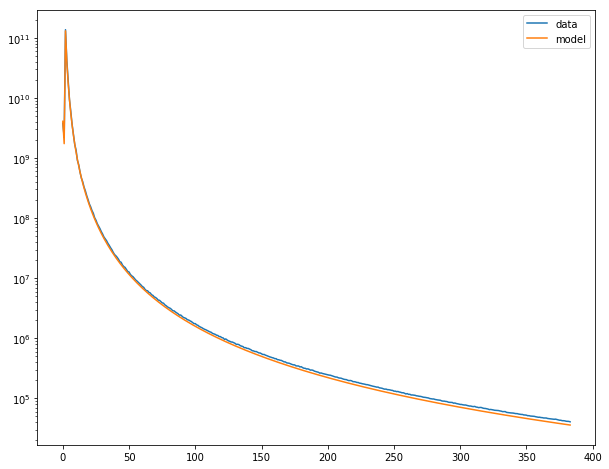

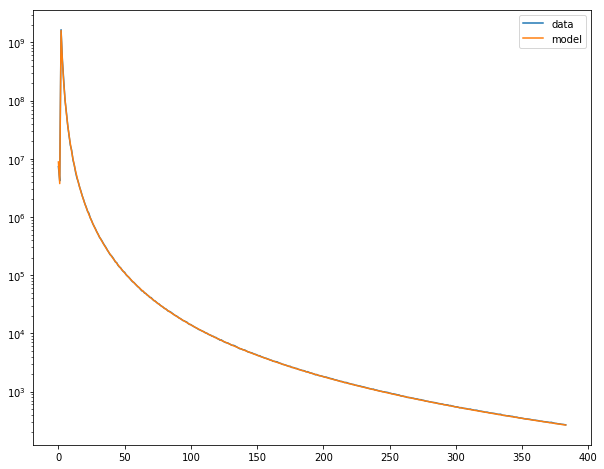

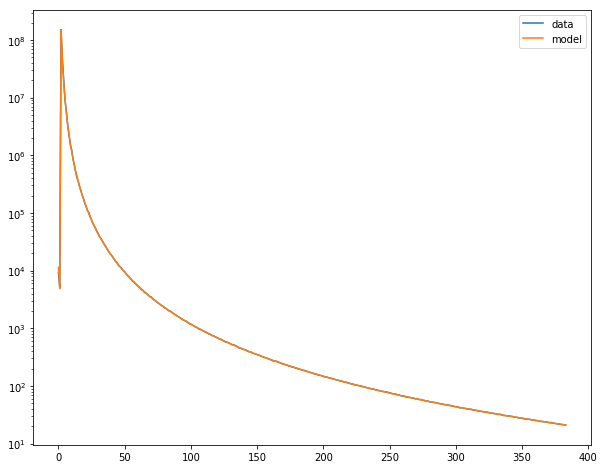

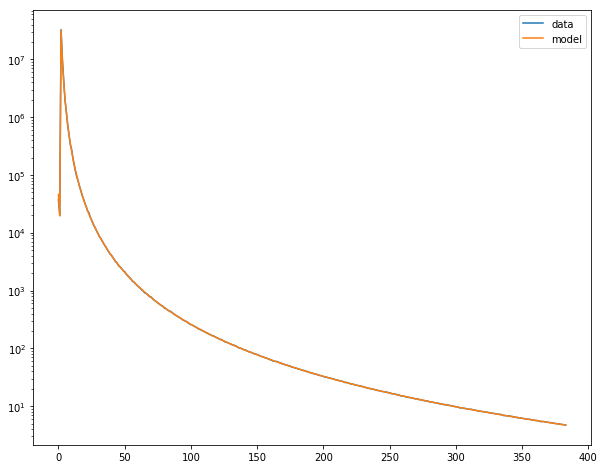

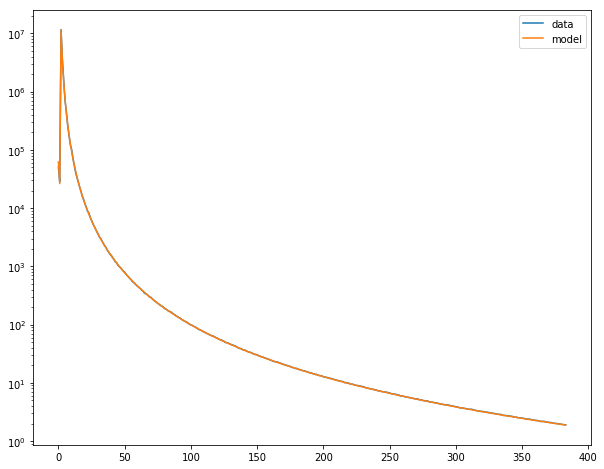

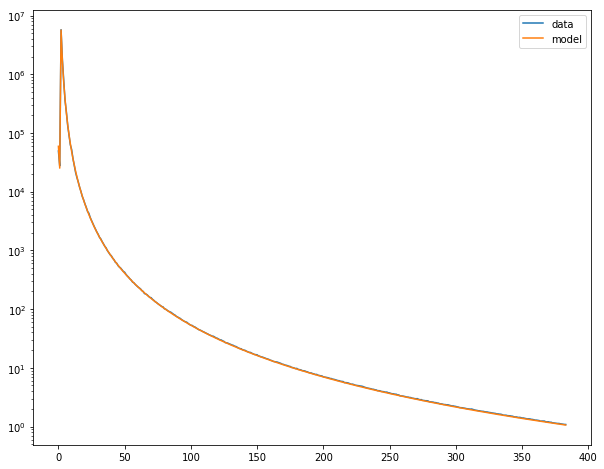

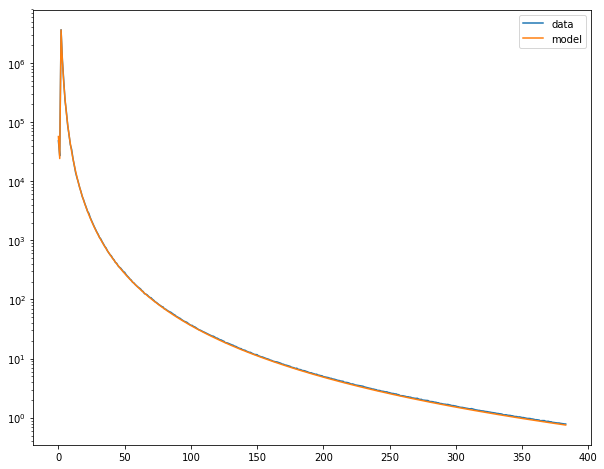

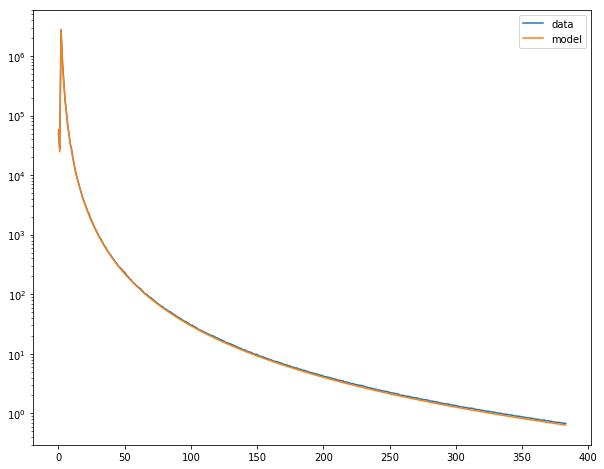

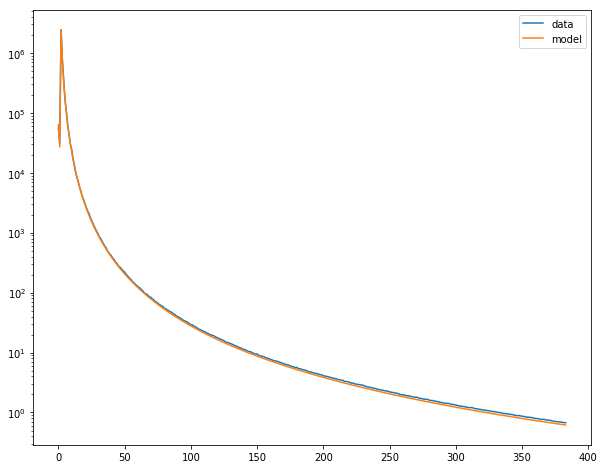

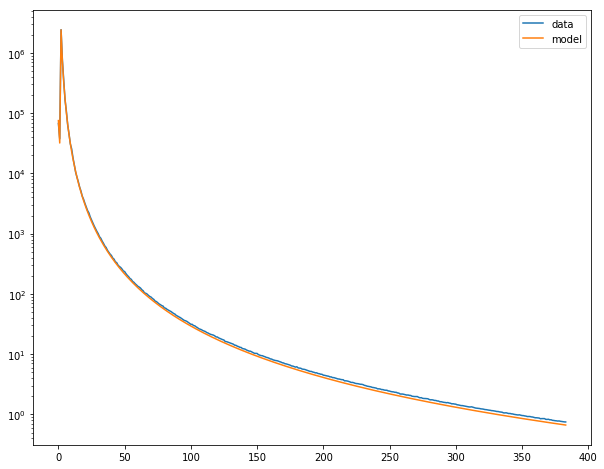

In [52]:
for i in range(len(freqs)):
    figure(figsize=(10,8))
    semilogy(PS_data[i], label='data')
    semilogy(in_model[i], label='model')
    legend()

# define our objective function (chi2 with cosmic variance) -- ultimately modify this for the behaviour near the high end cut off tail? Add additional uncertainty due to finite precision of the map?

In [27]:
def chi2(params, ells, freqs, data):
    chi2=0
    A, alpha, beta, gamma = params
    model = ff.model(ells, freqs, params)
    
    var = np.zeros((len(freqs),len(ells)))
    for ell in range(len(ells)):
        var[:,ell] = 2/(2*ell+1)
    cosmic_var = var * model**2
    
    chi2 = (data[:,30:] - model[:,30:])**2 / cosmic_var[:,30:]
    return np.sum(chi2)

In [45]:
start=time.time()
result0 = minimize(chi2, [1e3, -1,-1,-2.8], args=(ells, freqs, PS_data), 
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (-2.8, -2.01)))
print(time.time()-start)
print(result0)

149.43836307525635
      fun: 169.93033465640548
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.70530257e-05, -1.63936420e-02,  1.61207936e-02,  4.61568561e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 370
      nit: 60
   status: 0
  success: True
        x: array([1711.21137828,   -3.01977737,   -3.2054858 ,   -2.45068996])


In [57]:
#oaky, so it's finding slightly better parameters than input, in particular there's an effective value of gamma
#that's slightly smaller than input (2% change) with 0.5% change in amplitude

In [47]:
x0 = result0.x
fit0 = ff.model(ells, freqs, x0)
print(chi2(input_params, ells, freqs, PS_data))
print(chi2(x0, ells, freqs, PS_data))
#is there something wrong with the objective function as written?

2788.9517877881963
169.93033465640548


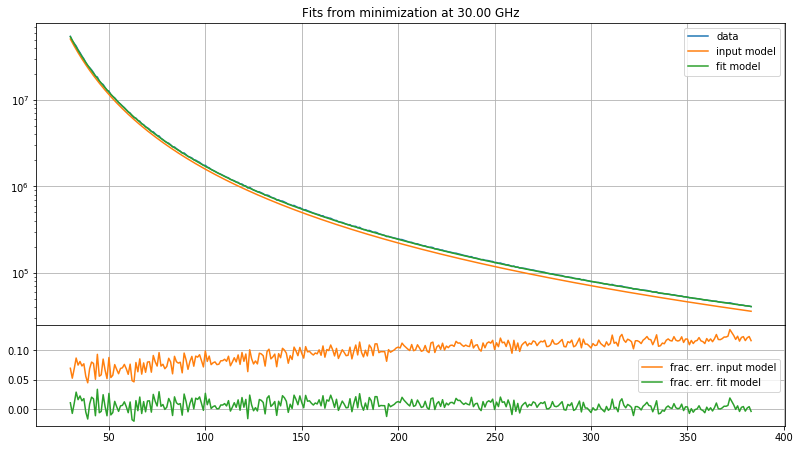

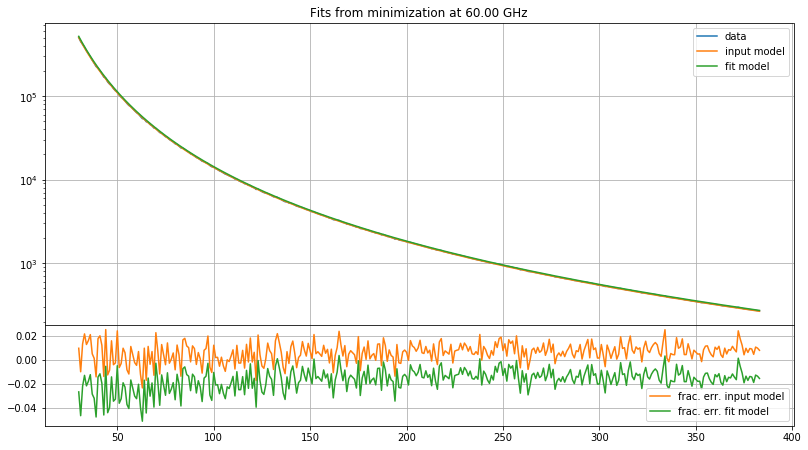

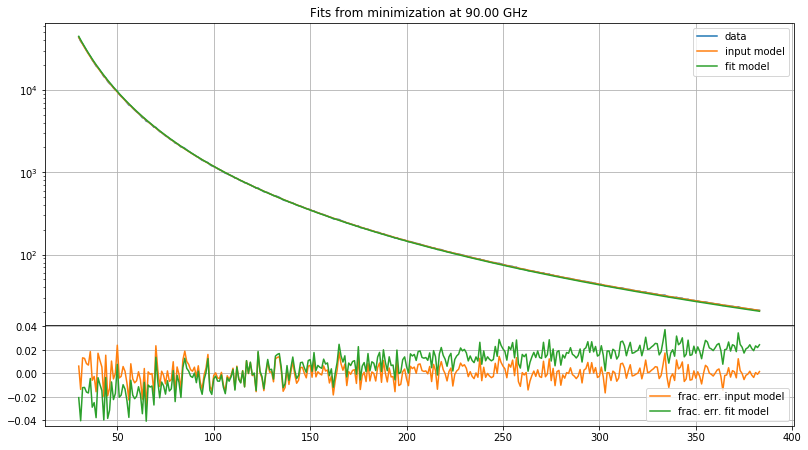

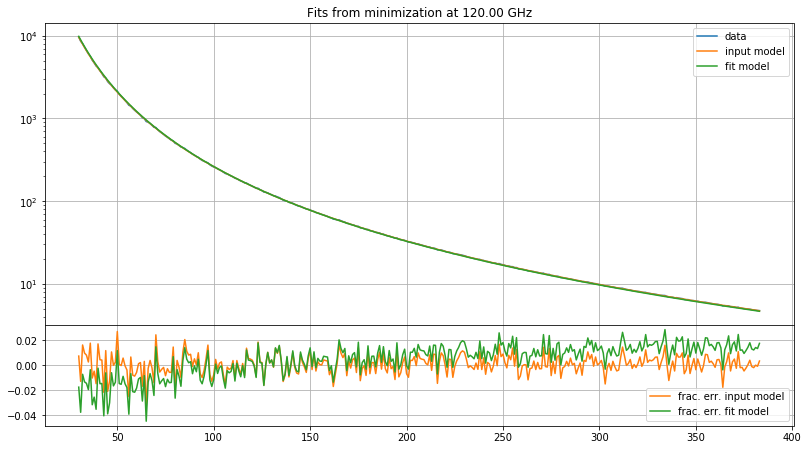

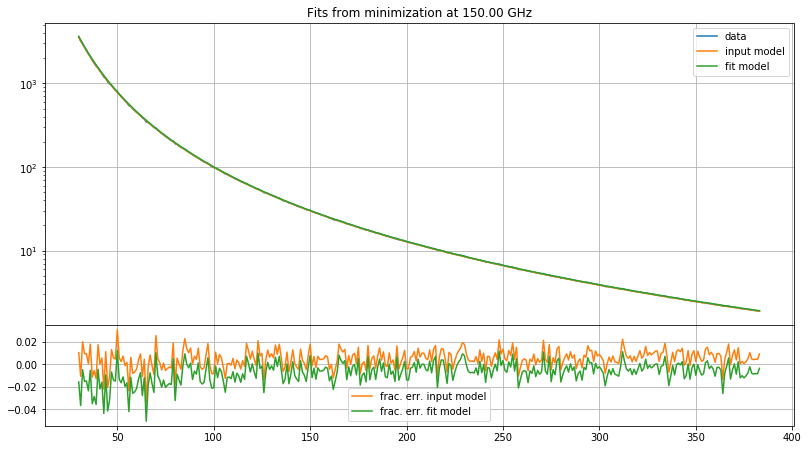

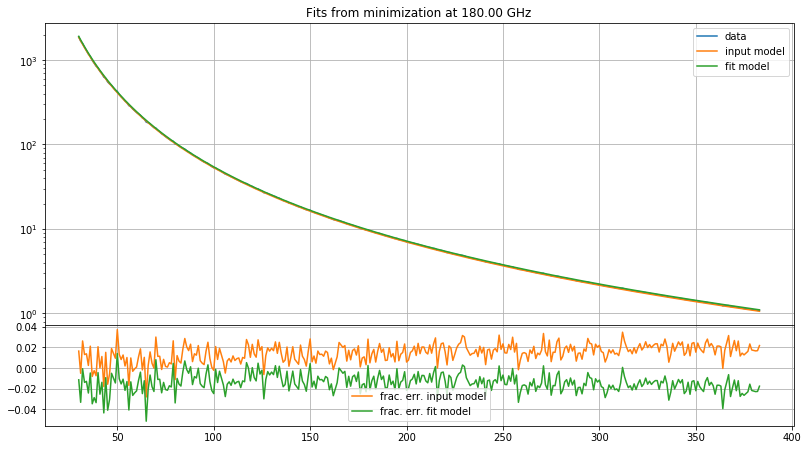

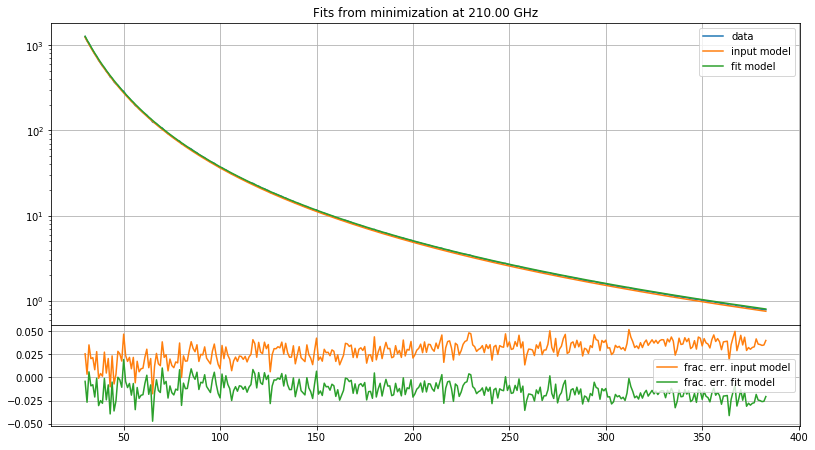

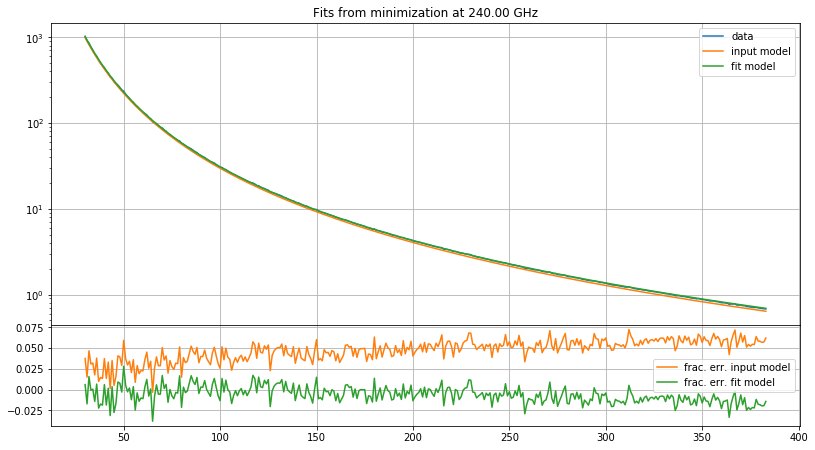

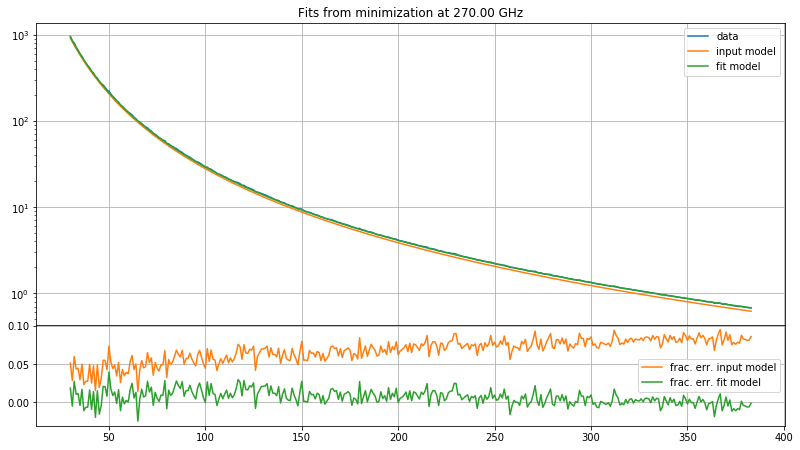

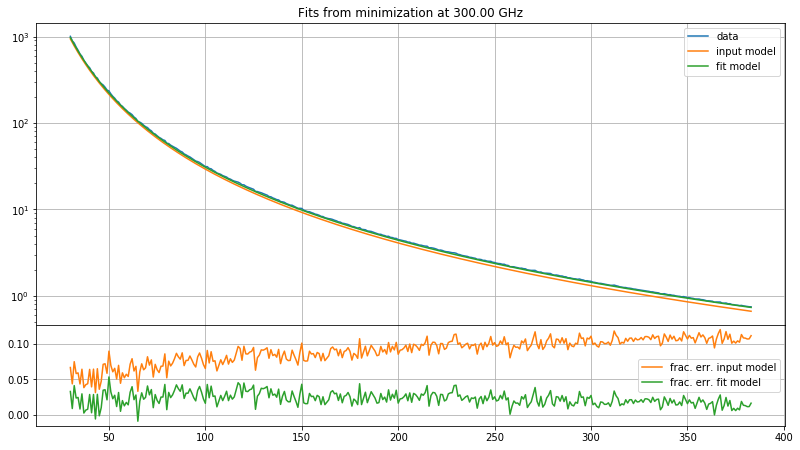

In [55]:
for i in range(len(freqs)):
    fig1 = figure(figsize=(13,7))
    frame1=fig1.add_axes((.1,.3,.8,.6))
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    semilogy(ells[30:], PS_data[i][30:], label='data')
    semilogy(ells[30:], in_model[i][30:], label='input model', color='C1')
    semilogy(ells[30:], fit0[i][30:], label='fit model', color='C2')
    grid()
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    
    
    
    frame2=fig1.add_axes((.1,.1,.8,.2)) 
    plot(ells[30:], (PS_data[i][30:]-in_model[i][30:])/PS_data[i][30:], color='C1', label='frac. err. input model')
    plot(ells[30:], (PS_data[i][30:]-fit0[i][30:])/PS_data[i][30:], color='C2', label='frac. err. fit model')
    legend()
    grid()


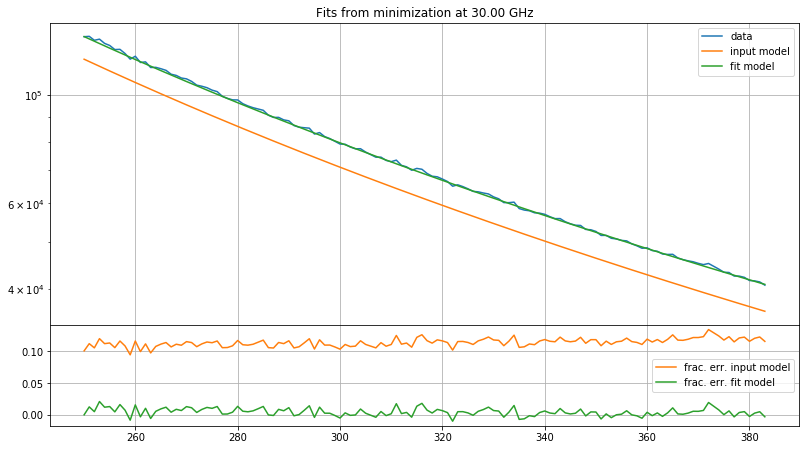

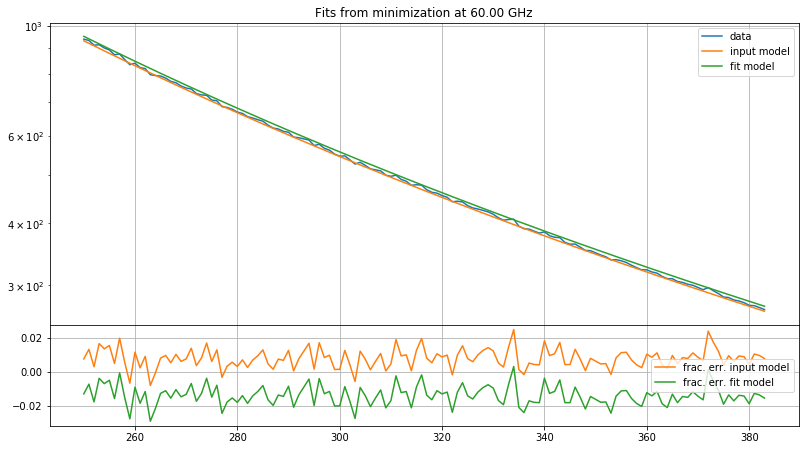

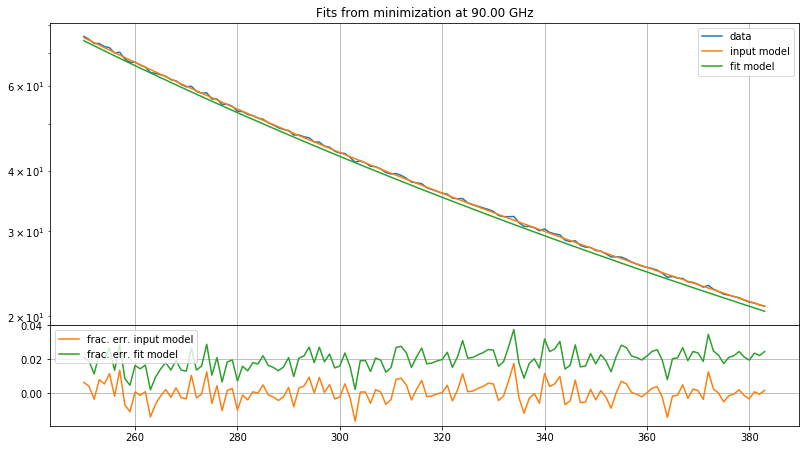

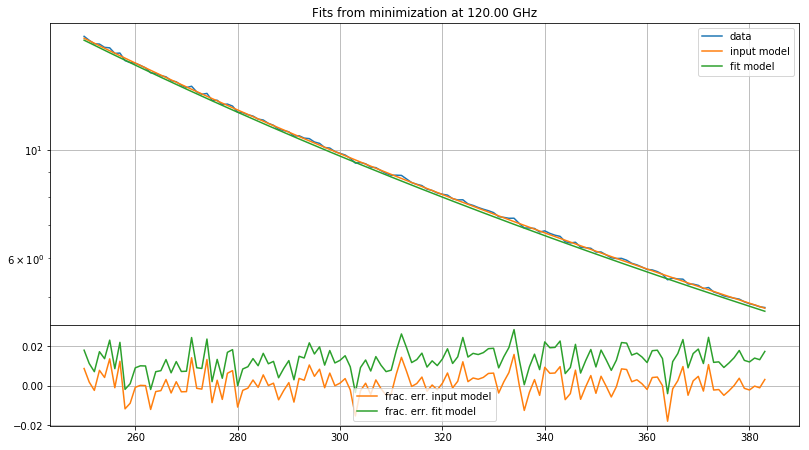

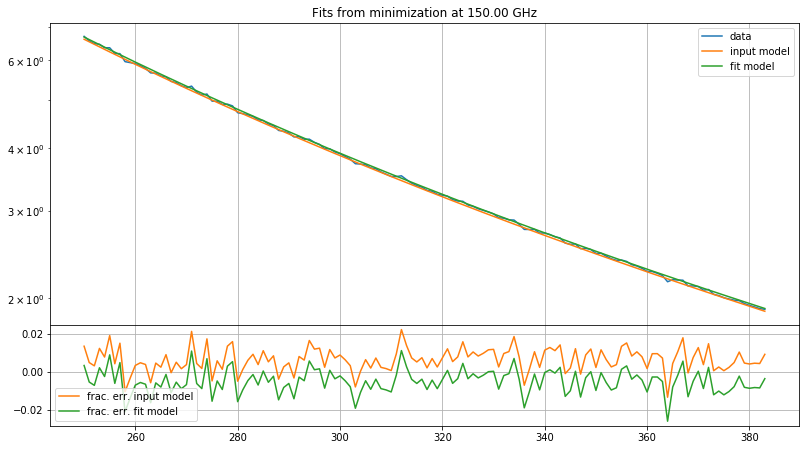

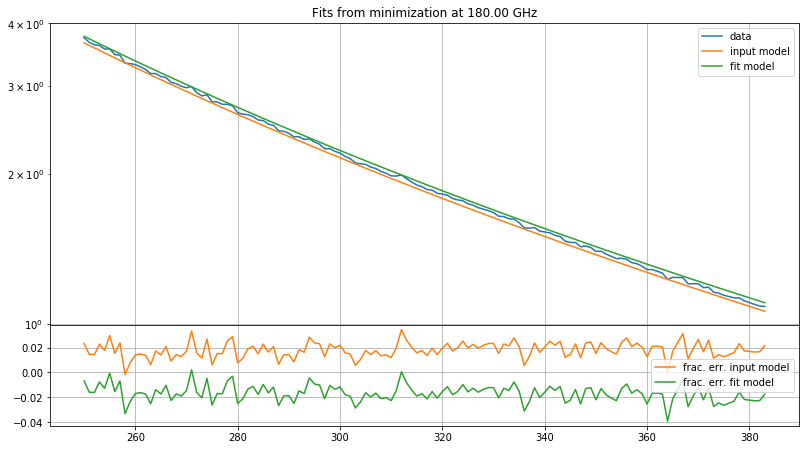

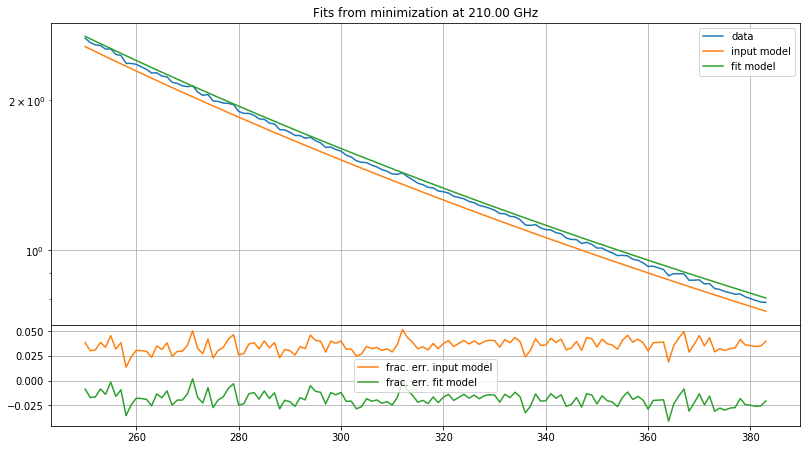

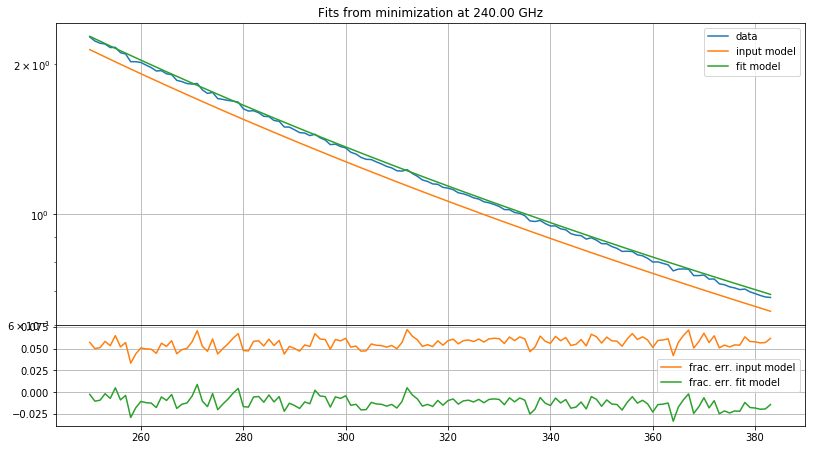

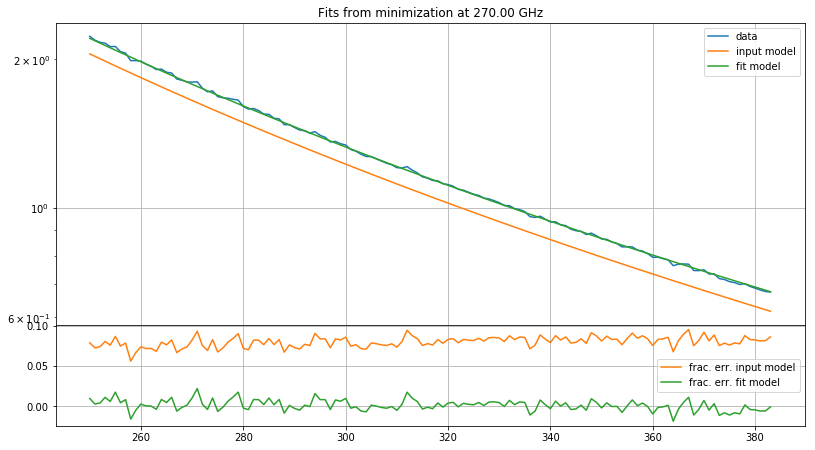

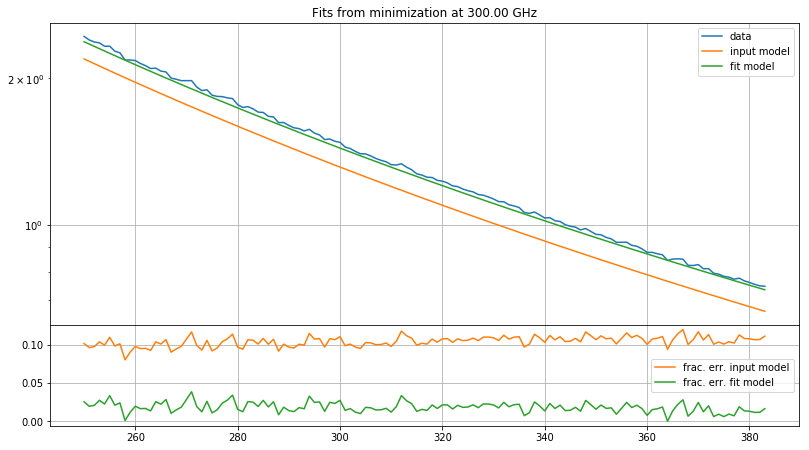

In [56]:
for i in range(len(freqs)):
    fig1 = figure(figsize=(13,7))
    frame1=fig1.add_axes((.1,.3,.8,.6))
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    semilogy(ells[250:], PS_data[i][250:], label='data')
    semilogy(ells[250:], in_model[i][250:], label='input model', color='C1')
    semilogy(ells[250:], fit0[i][250:], label='fit model', color='C2')
    grid()
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    
    
    
    frame2=fig1.add_axes((.1,.1,.8,.2)) 
    plot(ells[250:], (PS_data[i][250:]-in_model[i][250:])/PS_data[i][250:], color='C1', label='frac. err. input model')
    plot(ells[250:], (PS_data[i][250:]-fit0[i][250:])/PS_data[i][250:], color='C2', label='frac. err. fit model')
    legend()
    grid()
